# HW03 Data Clustering

## Basic Goal
1. Implement the mean-shift algorithm.

* Generate sampling points from a 2D Gaussian distribution
* Generate sampling points from a 2D Mixture of Gaussian (MOG) distribution
* Generate data via MoG

2. Estimate of generated data via step2 by using the Mean-Shift method
* Plot the clustering results

## Advanced Goal
* Implement the EM algorithm of MoG in 2-D case
* Add the regularization term to the MoG clustering implementation

## Mean-Shift Algorithm
1. Generate sampling points from a 2D Gaussian distribution

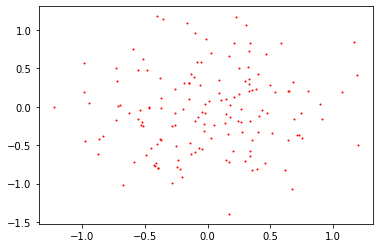

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_MoG(mu, sigma, size=150):
    assert type(mu) == list
    assert type(sigma) == list
    assert len(mu) == len(sigma)
    
    n = len(mu)
    g = [np.random.multivariate_normal(mu[i], np.diag(sigma[i]), size) for i in range(n)]

    return g

G_data = gen_MoG(mu=[[0,0]], sigma=[[0.25, 0.25]])
color = ['red', 'green', 'blue', 'cyan', 'yellow', 'gray', ]
for i, p in enumerate(G_data):
    plt.scatter(p[:, 0], p[:, 1], s=1, color=color[i])
plt.show()

2. Generate sampling points from a 2D Mixture of Gaussian (MOG) distribution & Generate data via MoG.

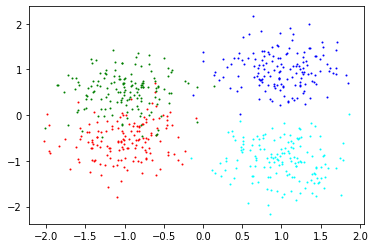

In [2]:
MoG_data = gen_MoG(mu=[[-1, -0.5], [-1, 0.5], [1, 1], [1, -1]], sigma=[[0.16, 0.16]] * 4)

for i, p in enumerate(MoG_data):
    plt.scatter(p[:, 0], p[:, 1], s=1, color=color[i])
plt.show()

3. Implement mean-shift algorithm and perform clustering.

In [10]:
class MeanShift(object):
    def __init__(self, data, kernel_bandwidth, stop_threshold, cluster_threshold):
        self.points = data
        self.kernel_bandwidth = kernel_bandwidth
        self.stop_threshold = stop_threshold
        self.cluster_threshold = cluster_threshold

    @staticmethod
    def dist(a, b):
        return np.linalg.norm(np.array(a) - np.array(b))

    @staticmethod
    def gaussian_kernel(distance, bandwidth):
        return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth)) ** 2)

    def fit(self):
        shift_points = np.array(self.points)
        shifting = [True] * self.points.shape[0]

        while True:
            max_dist = 0
            for i in range(0, len(shift_points)):
                if (i + 1) % 300 == 0:
                    print(i + 1, '/', len(shift_points), 'max_dist:', max_dist)
                if not shifting[i]:
                    continue
                p_shift_init = shift_points[i].copy()
                shift_points[i] = self._shift_point(shift_points[i], self.points)
                dist = self.dist(shift_points[i], p_shift_init)
                max_dist = max(max_dist, dist)
                shifting[i] = dist > self.stop_threshold

            if max_dist < self.stop_threshold:
                break

        cluster_ids = self._cluster_points(shift_points.tolist())
        return cluster_ids

    def _shift_point(self, point, shift_points):
        shift = np.array([0., 0.])
        scale = 0.
        for p in shift_points:
            dist = self.dist(point, p)
            weight = self.gaussian_kernel(dist, self.kernel_bandwidth)
            shift += weight * p
            scale += weight
        shift /= scale
        return shift

    def _cluster_points(self, shift_points):
        cluster_ids = []
        cluster_idx = 0
        cluster_centers = []

        for i, point in enumerate(shift_points):
            if len(cluster_ids) == 0:
                cluster_ids.append(cluster_idx)
                cluster_centers.append(point)
                cluster_idx += 1
            else:
                for center in cluster_centers:
                    dist = self.dist(point, center)
                    if(dist < self.cluster_threshold):
                        cluster_ids.append(cluster_centers.index(center))
                if len(cluster_ids) < i + 1:
                    cluster_ids.append(cluster_idx)
                    cluster_centers.append(point)
                    cluster_idx += 1
        return cluster_ids

300 / 600 max_dist: 0.720411272480401
600 / 600 max_dist: 0.720411272480401
300 / 600 max_dist: 0.34162281836219377
600 / 600 max_dist: 0.34162281836219377
300 / 600 max_dist: 0.25428594649188424
600 / 600 max_dist: 0.27599964311449465
300 / 600 max_dist: 0.17153744855124972
600 / 600 max_dist: 0.2013293447830127
300 / 600 max_dist: 0.20962811956433858
600 / 600 max_dist: 0.20962811956433858
300 / 600 max_dist: 0.165601438719291
600 / 600 max_dist: 0.1701158853543858
300 / 600 max_dist: 0.0927124896238396
600 / 600 max_dist: 0.10902825535169054
300 / 600 max_dist: 0.044539903741707625
600 / 600 max_dist: 0.07860845697301885
300 / 600 max_dist: 0.030837301290318357
600 / 600 max_dist: 0.12704361623604996
300 / 600 max_dist: 0.025644480851626045
600 / 600 max_dist: 0.1774592349494273
300 / 600 max_dist: 0.021559172077779357
600 / 600 max_dist: 0.18402106257742262
300 / 600 max_dist: 0.01826945265037169
600 / 600 max_dist: 0.1317784040114799
300 / 600 max_dist: 0.015572871816819002
600 / 

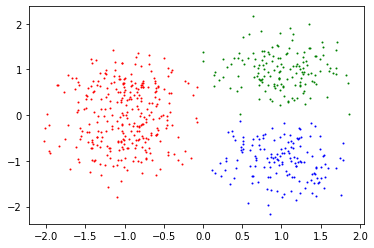

In [11]:
# Mean Shift
points = np.concatenate(MoG_data, axis=0)
ms = MeanShift(points, 0.5, 1e-3, 1e-1)
cluster = ms.fit()
color = ['red', 'green', 'blue', 'cyan', 'yellow', 'gray', ]
for i, p in enumerate(points):
    plt.scatter(p[0], p[1], s=1, color=color[cluster[i]])
plt.show()

## E-M Algorithm

In [12]:
import matplotlib.patches as patches

class EM(object):
    def __init__(self, data, ndim, p_sample, init_mu, init_sigma, max_iter=10, eps=.1):
        self.data = data
        self.ndim = ndim
        self.p_sample = p_sample
        self.mu = init_mu
        self.sigma = init_sigma
        self.max_iter = max_iter
        self.eps = eps
    
    def E(self):
        n_samples = self.data.shape[0]
        p_estimate = np.zeros(shape=(self.ndim, n_samples))
        p_estimate_sum = np.zeros(shape=(1, n_samples))
        for j in range(n_samples):
            for i in range(self.ndim):
                p_gaussian = 1 / np.sqrt(((2 * np.pi) ** 2) * np.linalg.det(self.sigma[i])) * np.exp(-0.5 * np.dot(np.dot((self.data[j] - self.mu[i]), np.linalg.inv(self.sigma[i])), (self.data[j] - self.mu[i]).T))
                p_estimate[i][j] = self.p_sample[i] * p_gaussian
                p_estimate_sum[:,j] += p_estimate[i][j]
        p_estimate = p_estimate / p_estimate_sum
        
        return p_estimate
    
    def M(self, p_estimate):
        n_samples = self.data.shape[0]
        ndim = p_estimate.shape[0]

        mu_estimate_sum = [0 for i in range(ndim)]
        mu_estimate = [0 for i in range(ndim)]
        sigma_estimate_sum = [0 for i in range(ndim)]
        sigma_estimate = [0 for i in range(ndim)]
        n_estimate = np.sum(p_estimate, axis=1)

        for i in range(ndim):
            for j in range(n_samples):
                mu_estimate_sum[i] += p_estimate[i][j] * self.data[j]
            mu_estimate[i] = mu_estimate_sum[i] / n_estimate[i]     # mean

        for i in range(ndim):
            sigma_estimate_sum[i] = np.zeros(shape=(2,2))
            for j in range(n_samples):
                sigma_estimate_sum[i] += p_estimate[i][j] * np.dot((self.data[j] - mu_estimate[i]).reshape(-1,1), (self.data[j] - mu_estimate[i]).reshape(1,-1))
            sigma_estimate[i] = sigma_estimate_sum[i] / n_estimate[i]

        return mu_estimate, sigma_estimate
    
    def EM(self):
        
        color = ['red', 'green', 'blue', 'cyan', 'yellow', 'gray', ]
        n_samples = self.data.shape[0]
        p_estimate = np.zeros(shape=(self.ndim, n_samples))

        for i in range(self.max_iter):
            ells = [patches.Ellipse(xy = self.mu[j], width = 6 * np.sqrt(self.sigma[j][0][0]), height = 6 * np.sqrt(self.sigma[j][1][1])) for j in range(self.ndim)]
            fig = plt.figure(1, figsize=(18,10))
            ax = fig.add_subplot(1,1,1)
            ax.set_title('Iteration: {}'.format(i+1))
            for j, e in enumerate(ells):
                ax.add_artist(e)
                e.set_clip_box(ax.bbox)
                e.set_alpha(1)
                e.set_facecolor('none')
                e.set_edgecolor(color[j])
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            plt.scatter(self.data[:,0], self.data[:,1], color='black', s=1)
            
            # plt.savefig('EM_iterations_ndim4.png')
            
            p_estimate = self.E()
            # update
            old_mu = self.mu
            self.mu, self.sigma = self.M(p_estimate=p_estimate)

            loss = np.sum(np.sum(np.abs(np.array(old_mu) - np.array(self.mu))))
            print("Iterations: ", i+1, ", Loss: ", loss)

            if loss < self.eps:
                plt.show()
                break
            else:
                plt.show()
        
        return


Iterations:  1 , Loss:  2.2624239674411615


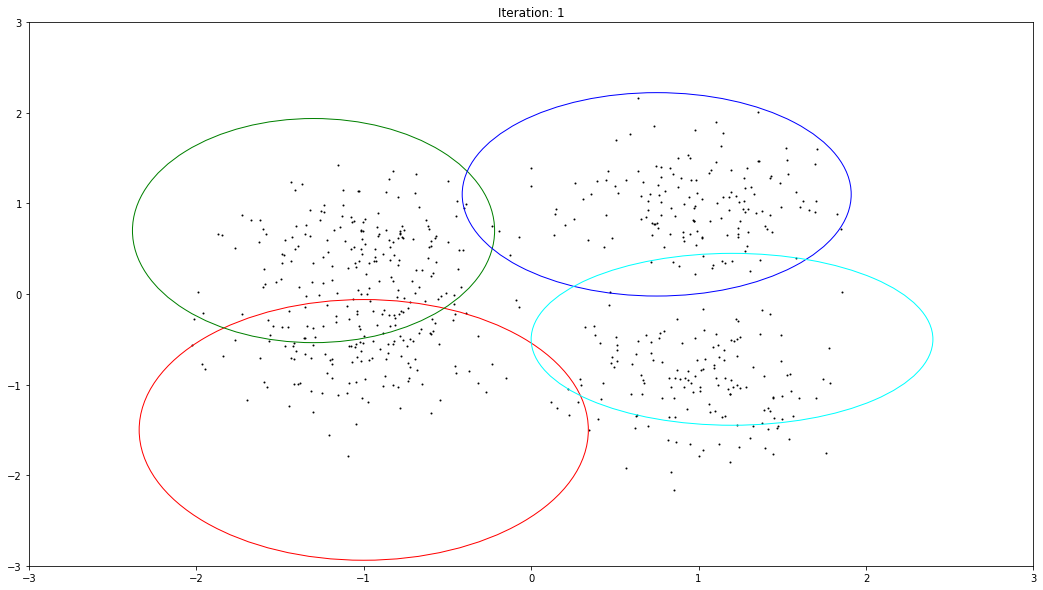

Iterations:  2 , Loss:  0.34457399998863314


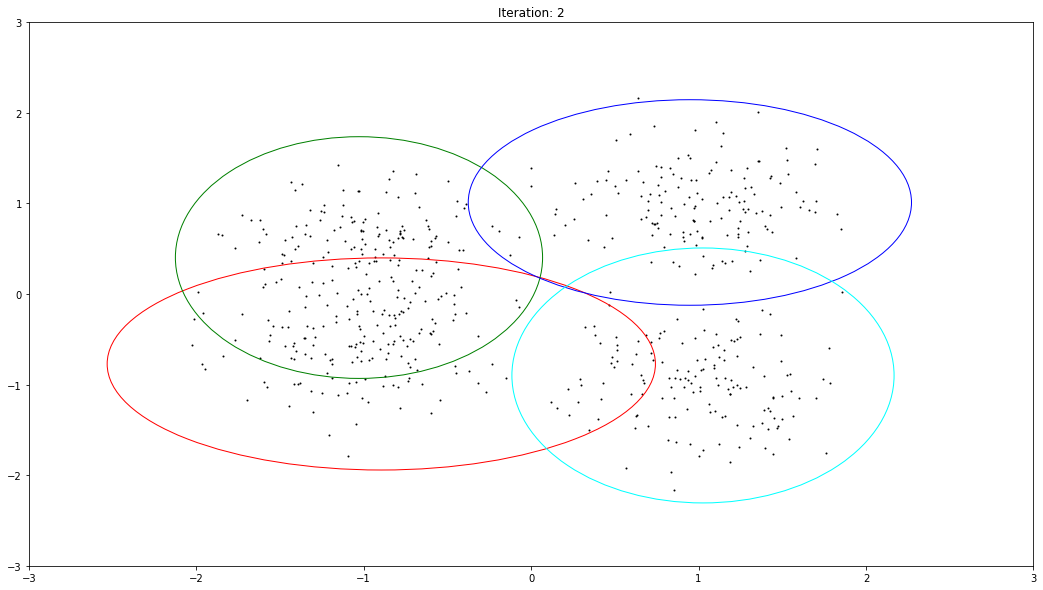

Iterations:  3 , Loss:  0.16057267895174665


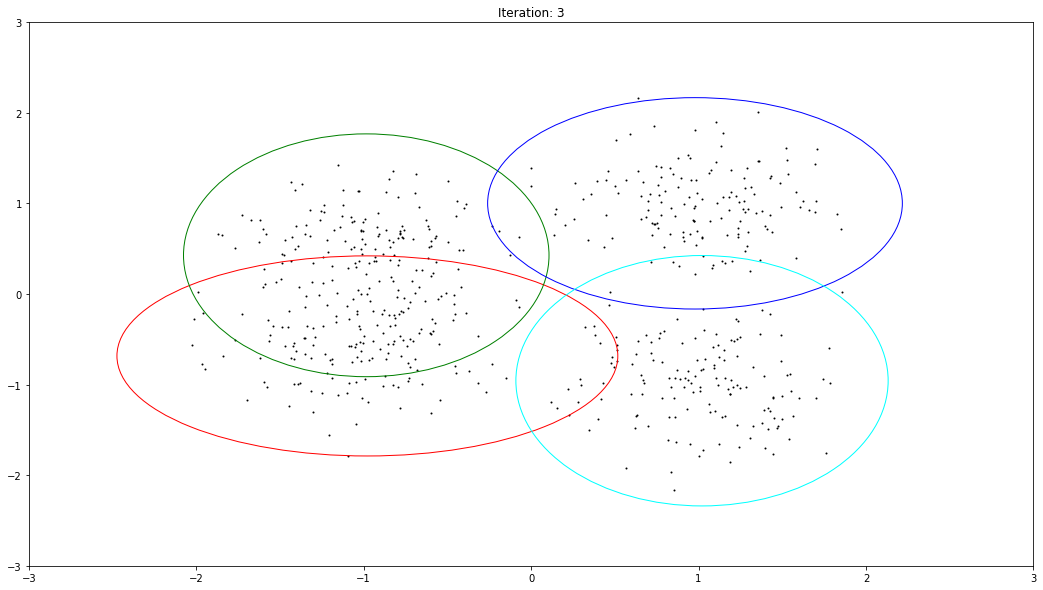

Iterations:  4 , Loss:  0.09244723534637095


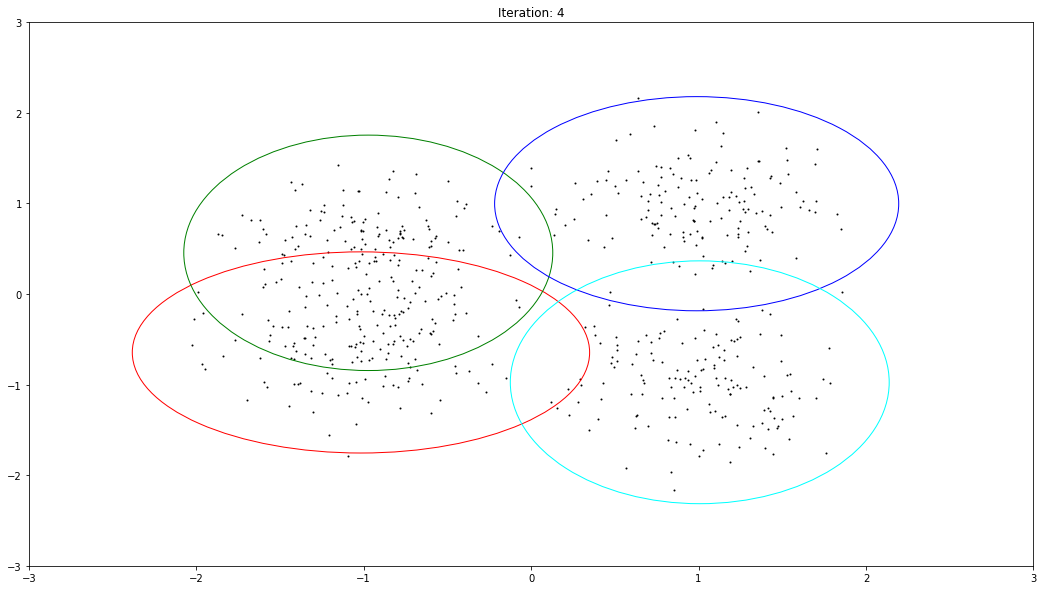

In [13]:
em = EM(data=points, ndim=4, p_sample = [0.25, 0.25, 0.25, 0.25],
                        init_mu = [[-1, -1.5], [-1.3, 0.7], [0.75, 1.1], [1.2, -0.5]],
                        init_sigma = [
                            [[0.2,0],[0,0.23]],
                            [[0.13,0],[0,0.17]],
                            [[0.15,0],[0,0.14]],
                            [[0.16,0],[0,0.1]],
                        ])
em.EM()